<a href="https://colab.research.google.com/github/seun829/DataScience/blob/main/Unit4/SeunLee_U4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling the Total Rebounds by NBA Players Throughout the 23-24 Season

First I will import all required tools

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv

# Intro

In this project, I will model the Total Rebounds of NBA players throughout history (TRB). I will use a Hierarchical model and then convert it to a Non-hierarchical model to see how that affects the posterior.

Going into this, I think that the hierarchical model will create quite a difference in the forest plot.

# Causal Diagram

First I will create a causal diagram to show what is going on.

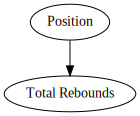

In [3]:
dag = gv.Digraph(comment='basketball_dag_nh')

dag.node('M', 'Position')
dag.node('S','Total Rebounds')

dag.edges(['MS'])
dag

# Hierarchical

I will first prepare my data.

In [ ]:
link = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"
basketball_data = pd.read_csv(link,dtype={'Pos':'category'})
basketball_data

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


In [ ]:

#this is an array of the positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball_data.Pos.cat.codes.values

#an array of the four strings that represent position
pos_codes = basketball_data.Pos.cat.categories

#puts coords in a dict, so pymc can read them
basketball_coords = {"Pos": pos_codes}

In [ ]:
with pm.Model(coords=basketball_coords) as basketball_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all
    μ_mu = pm.StudentT('μ_mu', nu=3, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=3, sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ',
                  nu=3,
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "Pos")

    σ = pm.HalfStudentT('σ', nu=3, sigma = 10,
                      dims = "Pos")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu=3,
                  mu = μ[pos_idx], #I include the prior in my likelihood
                  sigma = σ[pos_idx], #I include the prior in my likelihood
                  observed = basketball_data.TRB)

    idata_basketball_h = pm.sample(progressbar=False)

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Now I will use the sample posterior predicitive to see if my observed aligns with what the model predicts. I will use a positive limit because obviously you cannot have 0 total rebounds.

In [ ]:
pm.sample_posterior_predictive(idata_basketball_h, model=basketball_h_model, extend_inferencedata=True, progressbar=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 1200.0)

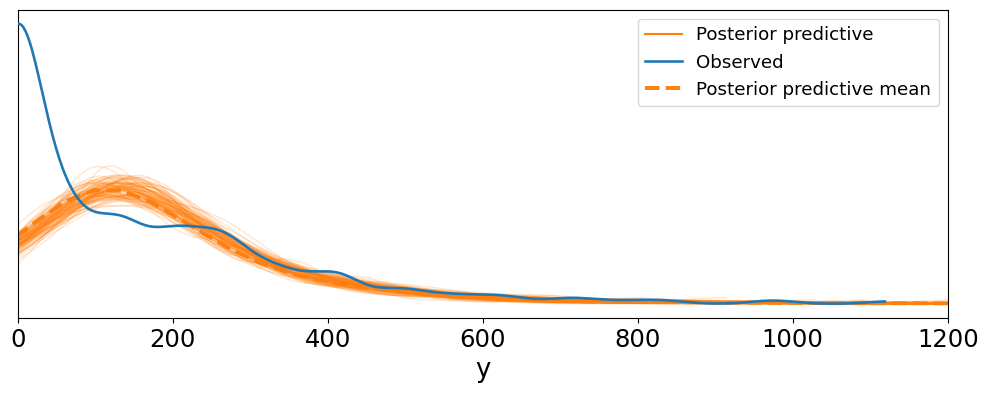

In [ ]:
az.plot_ppc(idata_basketball_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.xlim([0,1200])

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_sd'}>,
        <Axes: title={'center': 'μ_sd'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

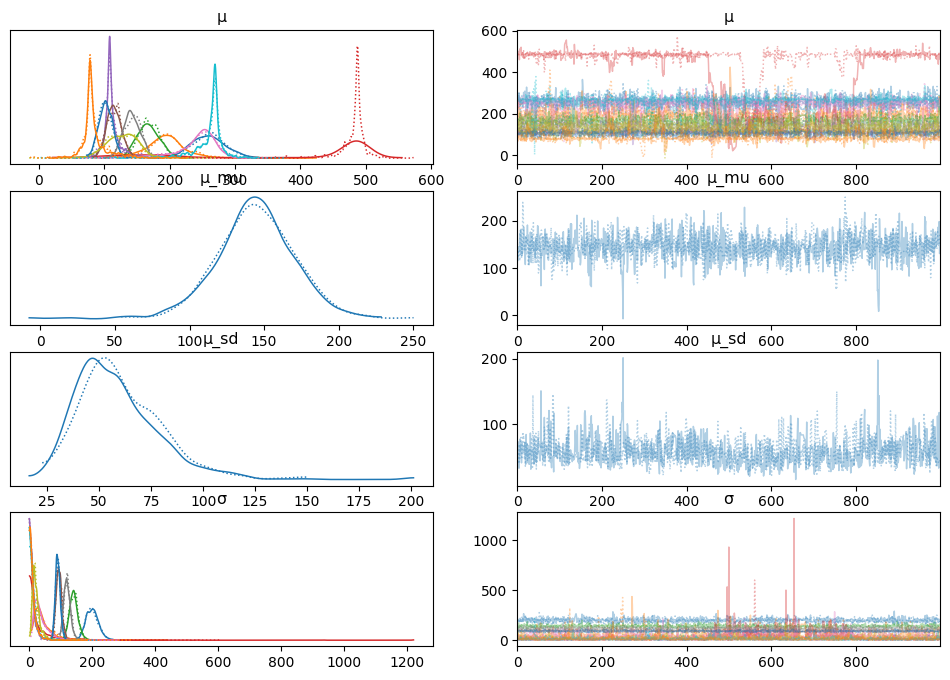

In [ ]:
az.plot_trace(idata_basketball_h)

Everything looks pretty normal so far, but I think the Non-hierarchial model will have either shifted over values or have a largely different range.

# Non-hierarchial


Now I will make the model non-hierarchial by not having priors inside priors.

In [ ]:
with pm.Model(coords=basketball_coords) as basketball_nh_model:
    μ = pm.StudentT('μ',
                  nu=3,
                  mu = 0, # I include the hyperprior in my prior
                  sigma = 10, # I include the hyperprior in my prior
                  dims = "Pos")

    σ = pm.HalfStudentT('σ', nu=3, sigma = 10,
                      dims = "Pos")

    #likelihood; same as before
    y = pm.StudentT('y',
                  nu=3,
                  mu = μ[pos_idx], #I include the prior in my likelihood
                  sigma = σ[pos_idx], #I include the prior in my likelihood
                  observed = basketball_data.TRB)

    idata_basketball_nh = pm.sample(progressbar=False)

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Now I will use the sample posterior predicitive to see if my observed aligns with what the model predicts. I will set the limit to positive, like last time.

In [ ]:
pm.sample_posterior_predictive(idata_basketball_nh, model=basketball_nh_model, extend_inferencedata=True, progressbar=False)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(0.0, 1200.0)

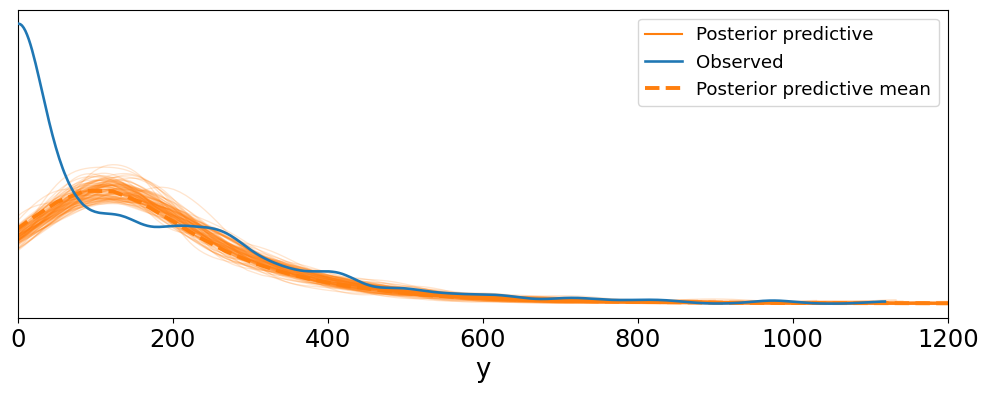

In [ ]:
az.plot_ppc(idata_basketball_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
plt.xlim([0,1200])

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

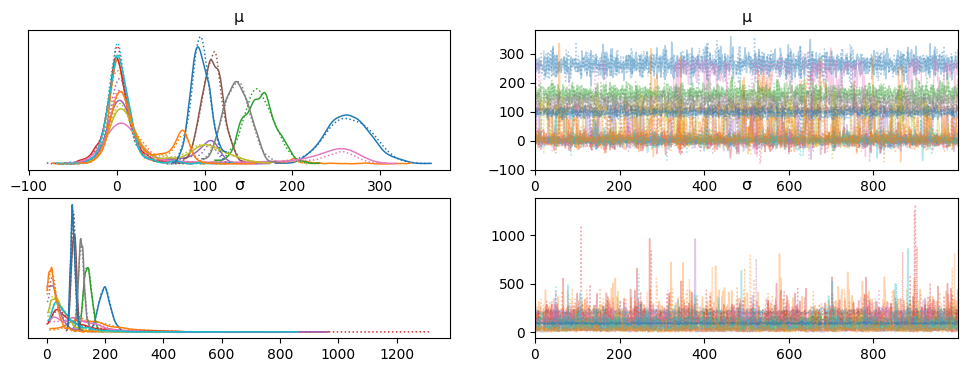

In [ ]:
az.plot_trace(idata_basketball_nh)

The traces are pretty noticeably different, with the non-hierarchical model having less to go off of.

Now I will compare hierarchical and non-hierarchical models through a ridgeplot.

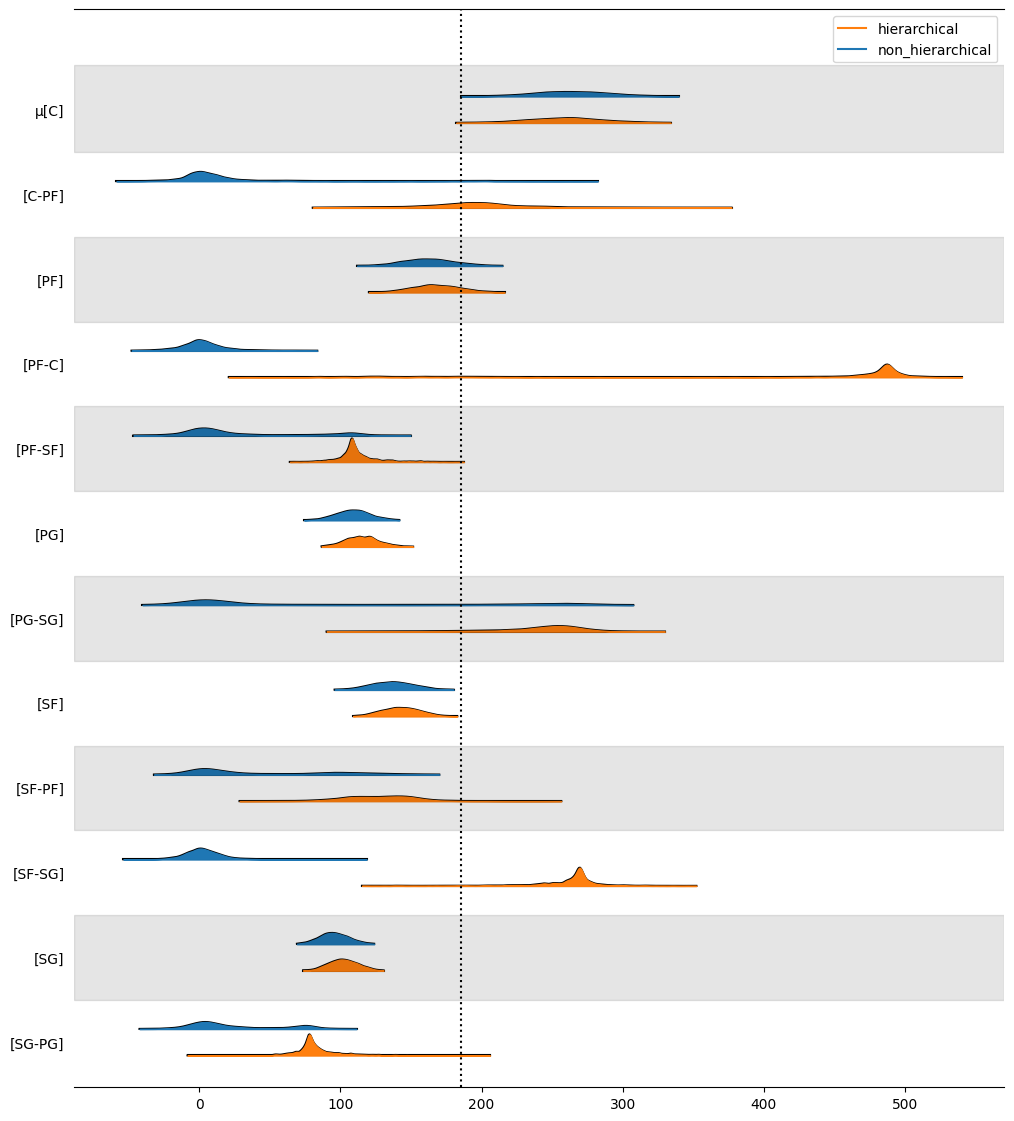

In [ ]:
axes = az.plot_forest([idata_basketball_nh, idata_basketball_h], kind="ridgeplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_basketball_h.posterior['μ'].mean(), *y_lims, color="k", ls=":");

# Conclusion

After looking at the results, I see that the hierarchical model either is around the non-hierarchical model or the hierarchial model is shifted over to the right. This could be due to multiple reasons, but I believe the main cause might be that the larger pool allowed for a lot more positive values.

The hierarchical model is also sometimes narrower, which would be because the estimates are more defined, and possibly more accurate.